# 1. Подготовка данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

## 1.1. Загрузка датасета и фильтрация по стране

In [2]:
df_full = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv')
print(f"Размер датасета: {df_full.shape}")
print(f"Столбцы: {list(df_full.columns)}")
print(df_full.head())

print("\nИнформация о датасете:")
print(df_full.info())

print(f"\nПропущенные значения:")
print(df_full.isnull().sum())

Размер датасета: (577462, 4)
Столбцы: ['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country']
           dt  AverageTemperature  AverageTemperatureUncertainty Country
0  1743-11-01               4.384                          2.294   Åland
1  1743-12-01                 NaN                            NaN   Åland
2  1744-01-01                 NaN                            NaN   Åland
3  1744-02-01                 NaN                            NaN   Åland
4  1744-03-01                 NaN                            NaN   Åland

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country

In [3]:
print(f"\nПример стран в датасете:")
print(df_full['Country'].value_counts().tail(50))


Пример стран в датасете:
Country
South America                                1953
Oceania                                      1935
Australia                                    1935
New Zealand                                  1929
Philippines                                  1929
Peru                                         1901
Bolivia                                      1901
Argentina                                    1901
Chile                                        1901
Cameroon                                     1893
Gabon                                        1893
Chad                                         1893
Central African Republic                     1893
Nigeria                                      1893
Sao Tome And Principe                        1893
Sudan                                        1893
Congo                                        1893
Equatorial Guinea                            1893
Swaziland                                    1881
South Africa    

Для дальнейшего анализа возьмем данные по Австралии.

In [4]:
country_data = df_full[df_full['Country'] == 'Australia'].copy()
print(f"Размер данных для Австралии: {country_data.shape}")

Размер данных для Австралии: (1935, 4)


## 1.2. Преобразование индекса в дату, проверка пропусков/частоты

In [5]:
# Преобразуем формат даты
country_data['dt'] = pd.to_datetime(country_data['dt'])

# Устанавливаем дату как индекс
country_data.set_index('dt', inplace=True)

# Сортируем данные по индексу
country_data.sort_index(inplace=True)

Оставим только нужные данные.

In [6]:
df = country_data[['AverageTemperature']]

print(f"Размер очищенных данных: {df.shape}")
print(f"Первые 10 записей:")
print(df.head(10))
print(df.describe())

Размер очищенных данных: (1935, 1)
Первые 10 записей:
            AverageTemperature
dt                            
1852-07-01              14.116
1852-08-01              15.330
1852-09-01              18.740
1852-10-01              21.984
1852-11-01              24.073
1852-12-01              26.888
1853-01-01              26.953
1853-02-01              25.905
1853-03-01              24.071
1853-04-01              20.587
       AverageTemperature
count         1930.000000
mean            21.624697
std              4.892714
min             12.529000
25%             17.035750
50%             22.129500
75%             26.258500
max             29.861000


In [7]:
# Убедимся, что индекс — DatetimeIndex
if isinstance(df.index, pd.DatetimeIndex):
    print('Индекс - это дата')
else:
    print('Индекс - это не дата, исправляем')
    df.index = pd.to_datetime(df.index)

# Проверим на дубликаты по датам
if df.index.duplicated().any():
    print("Найдены дублирующиеся даты")
else:
    print("Дубликатов дат нет")

# Пропуски
start, end = df.index.min(), df.index.max()
expected = pd.date_range(start, end, freq='MS')
if df.index.equals(expected):
    print("Пропусков по датам нет. Ряд полный.")
else:
    print("Найдены пропуски или лишние даты")
    print("Фактических записей:", len(df))
    print("Ожидаемо:", len(expected))

# Пропуски данных
print("Количество пропусков в данных:", df['AverageTemperature'].isna().sum())

Индекс - это дата
Дубликатов дат нет
Пропусков по датам нет. Ряд полный.
Количество пропусков в данных: 5


Есть 5 пропусков значений.
Заполним их средним значением для соответствующего месяца.

In [8]:
df['AverageTemperature'] = df.groupby(df.index.month)['AverageTemperature'].transform(
    lambda x: x.fillna(x.mean())
)

Итог - временной ряд был полный, без дубликатов дат, то есть по одному значению на каждый месяц.
Были обнаружены пропуски, которые заполнены средним значением для соответствующего месяца

## 1.3. Построение базового графика временного ряда

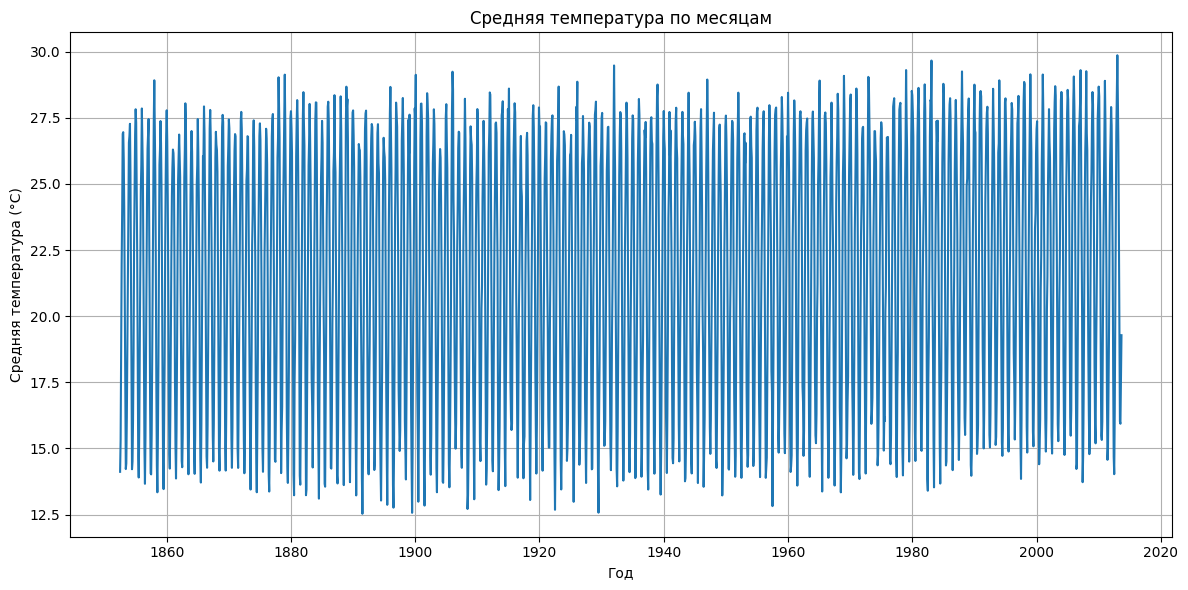

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['AverageTemperature'])
plt.title('Средняя температура по месяцам')
plt.xlabel('Год')
plt.ylabel('Средняя температура (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Holdout-разбиение.

## 2.1. Корректное деление 80% train / 20% test по времени

In [10]:
# Количество строк данных
n = len(df)

# Индекс точки разделения на трэйн и тест
split_idx = int(0.8 * n)

# Делим данные
train_data = df.iloc[:split_idx]
test_data = df.iloc[split_idx:]

print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Размер тестовой выборки: {len(test_data)}")
print(f"Диапазон дат обучающей выборки: {train_data.index.min()} - {train_data.index.max()}")
print(f"Диапазон дат тестовой выборки: {test_data.index.min()} - {test_data.index.max()}")


Размер обучающей выборки: 1548
Размер тестовой выборки: 387
Диапазон дат обучающей выборки: 1852-07-01 00:00:00 - 1981-06-01 00:00:00
Диапазон дат тестовой выборки: 1981-07-01 00:00:00 - 2013-09-01 00:00:00


Утечки по датам нет.

## 2.2. Визуализация train/test на одном графике

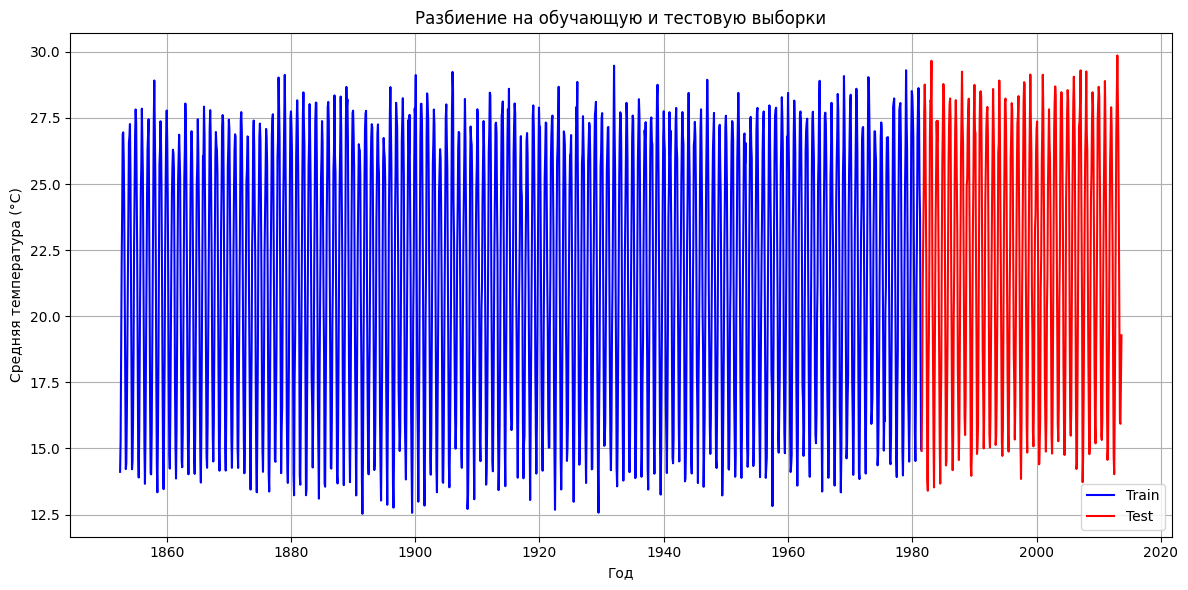

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['AverageTemperature'], label='Train', color='blue')
plt.plot(test_data.index, test_data['AverageTemperature'], label='Test', color='red')
plt.title('Разбиение на обучающую и тестовую выборки')
plt.xlabel('Год')
plt.ylabel('Средняя температура (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Скользящее окно.

## 3.1. Реализация скользящего окна (120 мес. обучение, 12 мес. прогноз)

In [12]:
train_window_size = 120
forecast_horizon = 12

print(f"Размер обучающего окна: {train_window_size} месяцев")
print(f"Прогнозный горизонт: {forecast_horizon} месяцев")

dates = df.index
values = df['AverageTemperature'].values

# Найдем все возможные разбиения
splits = []
for start_idx in range(0, len(dates) - train_window_size - forecast_horizon + 1, forecast_horizon):
    # Определяем индексы трэйна и теста
    train_idx_start = start_idx
    train_idx_end = start_idx + train_window_size
    test_idx_start = train_idx_end
    test_idx_end = test_idx_start + forecast_horizon
    
    # Производим разбиение
    train_split = (dates[train_idx_start:train_idx_end], values[train_idx_start:train_idx_end])
    test_split = (dates[test_idx_start:test_idx_end], values[test_idx_start:test_idx_end])
    
    splits.append((train_split, test_split))

print(f"Количество скользящих разбиений: {len(splits)}")


Размер обучающего окна: 120 месяцев
Прогнозный горизонт: 12 месяцев
Количество скользящих разбиений: 151


## 3.2. Визуализация хотя бы двух первых сплитов

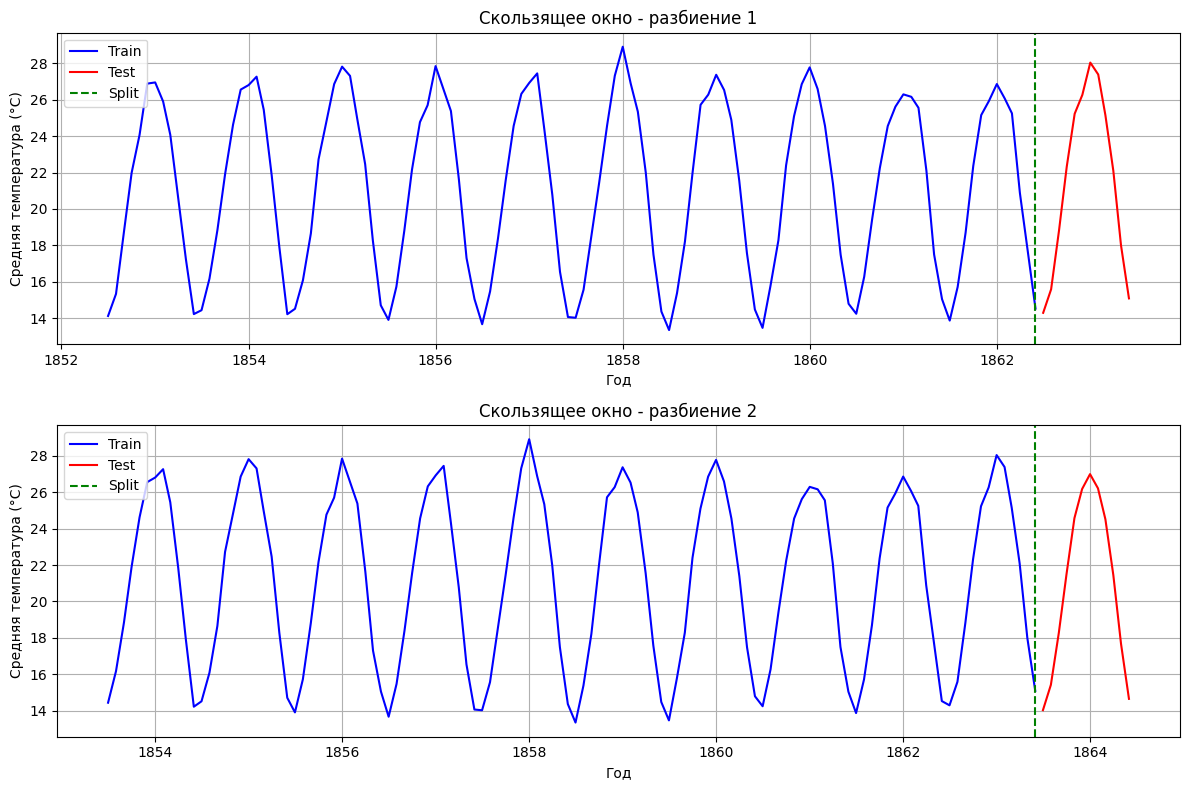

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

for i in range(2):
    train_dates, train_vals = splits[i][0]
    test_dates, test_vals = splits[i][1]
    
    ax = axes[i]
    ax.plot(train_dates, train_vals, label='Train', color='blue')
    ax.plot(test_dates, test_vals, label='Test', color='red')
    
    # Вертикальная линия для разделения трэйна и теста
    if len(train_dates) > 0:
        ax.axvline(x=train_dates[-1], color='green', linestyle='--', label='Split')
    
    ax.set_title(f'Скользящее окно - разбиение {i+1}')
    ax.set_xlabel('Год')
    ax.set_ylabel('Средняя температура (°C)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# 4. Генерация признаков.

## 4.1. Создание лагов (t-1, t-12)

In [14]:
# Добавляем лаги в трэйн и тест
train_data['lag_1'] = train_data['AverageTemperature'].shift(1)
train_data['lag_12'] = train_data['AverageTemperature'].shift(12)

test_data['lag_1'] = test_data['AverageTemperature'].shift(1)
test_data['lag_12'] = test_data['AverageTemperature'].shift(12)

## 4.2. Создание календарных признаков (номер месяца, индикатор зимы)

In [15]:
train_data['month'] = train_data.index.month
train_data['is_winter'] = train_data['month'].isin([12, 1, 2]).astype(int)

test_data['month'] = test_data.index.month
test_data['is_winter'] = test_data['month'].isin([12, 1, 2]).astype(int)


## 4.3. Вывод первых строк датафрейма с признаками

In [16]:
print(train_data.head(15))
print(test_data.head(15))

            AverageTemperature   lag_1  lag_12  month  is_winter
dt                                                              
1852-07-01              14.116     NaN     NaN      7          0
1852-08-01              15.330  14.116     NaN      8          0
1852-09-01              18.740  15.330     NaN      9          0
1852-10-01              21.984  18.740     NaN     10          0
1852-11-01              24.073  21.984     NaN     11          0
1852-12-01              26.888  24.073     NaN     12          1
1853-01-01              26.953  26.888     NaN      1          1
1853-02-01              25.905  26.953     NaN      2          1
1853-03-01              24.071  25.905     NaN      3          0
1853-04-01              20.587  24.071     NaN      4          0
1853-05-01              17.231  20.587     NaN      5          0
1853-06-01              14.220  17.231     NaN      6          0
1853-07-01              14.433  14.220  14.116      7          0
1853-08-01              1

# 5. Оценка прогноза.

## 5.1. Обучение простой модели (например, линейная регрессия)

In [17]:
# Подготовим фичи и таргет
feature_cols = ['lag_1', 'lag_12', 'month', 'is_winter']
# Убираем пропуски (из-за лагов)
train_data.dropna(inplace=True)

X = train_data[feature_cols]
y = train_data['AverageTemperature']

print(f"Размер признаков X: {X.shape}")
print(f"Размер целевой переменной y: {y.shape}")
print(f"Признаки: {feature_cols}")

# Обучаем модель линейной регрессии
model = LinearRegression()
model.fit(X, y)

print(f"Коэффициенты модели: {dict(zip(feature_cols, model.coef_))}")
print(f"Свободный член: {model.intercept_}")

Размер признаков X: (1536, 4)
Размер целевой переменной y: (1536,)
Признаки: ['lag_1', 'lag_12', 'month', 'is_winter']
Коэффициенты модели: {'lag_1': np.float64(0.13208010238823148), 'lag_12': np.float64(0.8568848291620783), 'month': np.float64(0.06781610491251072), 'is_winter': np.float64(0.32758602833165246)}
Свободный член: -0.2750154024293323


## 5.2. Прогноз на тестовой выборке holdout

In [18]:
# Убираем пропуски (из-за лагов)
test_data.dropna(inplace=True)

X_test = test_data[feature_cols]
y_test = test_data['AverageTemperature']

# Делаем предсказание
y_pred = model.predict(X_test)


# 6. Метрики и интерпретация

## 6.1. Расчёт MAE, RMSE, MAPE

In [19]:

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"\nМетрики на тестовом наборе данных:")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.4f}%")



Метрики на тестовом наборе данных:
MAE (Mean Absolute Error): 0.7986
RMSE (Root Mean Squared Error): 1.0131
MAPE (Mean Absolute Percentage Error): 3.7739%


## 6.2. Краткий комментарий (1-2 предложения о качестве прогноза)

Результаты на тестовой выборке выглядят хорошо:

  - MAE ≈ 0.80°C — в среднем модель ошибается на менее чем 1 градус по Цельсию, что для задачи прогнозирования среднемесячной температуры является очень неплохим результатом.
  - RMSE ≈ 1.01°C — немного выше MAE, что говорит об отсутствии сильных выбросов в ошибках (иначе RMSE был бы значительно больше).
  - MAPE ≈ 3.77% — относительная ошибка менее 4%, что подтверждает высокую точность модели, особенно учитывая природную изменчивость климатических данных.


Вывод: модель демонстрирует стабильное и точное прогнозирование температуры на тестовом периоде.